### Cálculo del conmutador de Engel

Esta función implementa de forma recursiva el **n-Engel conmutador** \([x, ny]\), 
que mide qué tan lejos está un elemento \(x\) de conmutar con \(y\) en el sentido de Engel.  
Para \(n = 0\) devuelve \(x\); para \(n ≥ 1\), aplica iterativamente la relación:

$[x, ny] = [[x, n-1y], y] = [x, n-1y]^{-1} y^{-1} [x, n-1y] y$

### Detección de elementos *Left Engel*

Verifica si un elemento \(x ∈ G\) es *left Engel*.  
Para ello, recorre todos los \(a ∈ G\) y busca un entero \(k\) tal que 
$[a, kx] = 1$.  
Si lo encuentra para todos los \(a\), entonces \(x\) pertenece a \(L(G)\).

### Construcción del grafo de Engel

Genera el **grafo de Engel \(E\_G\)** a partir del grupo \(G\).  
Primero identifica los elementos _left Engel_ para formar el conjunto \(L\(G\)\),  
y luego crea los vértices $V = G \setminus L(G)$.  

### Criterio de adyacencia entre elementos

Determina si dos elementos \(x, y ∈ G\) son adyacentes en el grafo de Engel.  
Son adyacentes si  **existen** potencias \(k\) tales que $[x, ky] = 1$.  
Esto causa que sea un grafo dirigido


In [17]:
def conmutador(x, y):
    """
    Calcula el conmutador [x,y] = x^(-1) * y^(-1) * x * y
    """
    return x^(-1) * y^(-1) * x * y


def n_engel_commutator(x, y, n):
    """
    Calcula el n-Engel conmutador [x, _n y] = [x, y, y, ..., y]
    Definición recursiva:
    - [x, _0 y] = x
    - [x, _1 y] = [x, y]
    - [x, _n y] = [[x, _(n-1) y], y]
    """
    if n == 0:
        return x
    
    # Calcular recursivamente
    result = x
    for i in range(n):
        result = conmutador(result, y)
        #print(result)
    
    return result


def hay_arista_dirigida(x, y, G, max_n=None):
    """
    Verifica si hay una arista dirigida de x a y.
    Esto ocurre si [x, _n y] = 1 para algún n ≥ 1.
    La relación NO es simétrica en general.
    """
    if max_n is None:
        max_n = G.order()
    
    identity = G.identity()
    
    # Verificar si [x, _n y] = 1 para algún n
    for n in range(1, max_n + 1):
        comm = n_engel_commutator(x, y, n)
        #print(comm)
        if comm == identity:
            #print(n)
            return True
    
    return False


def calcular_hipercentro(G, max_iter=10):
    """
    Calcula Z_∞(G) usando la serie central ascendente
    """
    Z_n = G.subgroup([G.identity()])
    
    for _ in range(max_iter):
        if Z_n == G:
            break
        
        # Encontrar elementos que centralizan módulo Z_n
        elementos_nuevos = []
        for g in G:
            esta_en_centro = True
            for h in G:
                conmutador_gh = conmutador(g, h)
                if conmutador_gh not in Z_n:
                    esta_en_centro = False
                    break
            
            if esta_en_centro:
                elementos_nuevos.append(g)
        
        Z_n_plus_1 = G.subgroup(elementos_nuevos)
        
        if Z_n_plus_1 == Z_n:
            break
            
        Z_n = Z_n_plus_1
    
    return Z_n 

### Función de creación de grafos



In [18]:
def grafo_engel(G, verbose=True):
    """
    Construye el grafo de Engel Γ_G según la definición:
    - V = G  Z_∞(G)
    - x ~ y si [x, _n y] = 1 para algún n
    """
    if verbose:
        print("=" * 60)
        print(f"Grupo: {G}")
        print(f"Orden: {G.order()}")
    
    # Calcular hipercentro
    Z_inf = calcular_hipercentro(G)
    
    if verbose:
        print(f"\nHipercentro Z_∞(G):")
        print(f"  Orden: {Z_inf.order()}")
        if Z_inf.order() <= 10:
            print(f"  Elementos: {list(Z_inf)}")
    
    # Vértices: G \ Z_∞(G)
    vertices = [g for g in G if g not in Z_inf]
    
    if verbose:
        print(f"\nVértices (G \\ Z_∞(G)): {len(vertices)}")
        if len(vertices) <= 10:
            print(f"  {vertices}")
    
    if len(vertices) == 0:
        if verbose:
            print("\n⚠️  El grafo es vacío (Z_∞(G) = G)")
        return None, []
    
    # Crear grafo
    Gamma = DiGraph(loops=True)
    vertex_labels = {}
    
    for v in vertices:
        label = str(v)
        vertex_labels[v] = label
        Gamma.add_vertex(label)
    
    # Calcular aristas
    if verbose:
        print("\nCalculando aristas...")
    
    aristas_count = 0
    for i, x in enumerate(vertices):
        for j, y in enumerate(vertices):
            if x != y:
                if hay_arista_dirigida(x, y, G):
                    Gamma.add_edge(vertex_labels[x], vertex_labels[y])
                    aristas_count += 1

    return Gamma, vertices


EJEMPLO 1: S_3 (Grupo Simétrico)
Grupo: Symmetric group of order 3! as a permutation group
Orden: 6

Hipercentro Z_∞(G):
  Orden: 1
  Elementos: [()]

Vértices (G \ Z_∞(G)): 5
  [(1,3,2), (1,2,3), (2,3), (1,3), (1,2)]

Calculando aristas...

Análisis de simetría:
  (1,3,2) → (1,2,3): recíproca (1,2,3) → (1,3,2) = True
  (1,2,3) → (1,3,2): recíproca (1,3,2) → (1,2,3) = True
  (2,3) → (1,3,2): recíproca (1,3,2) → (2,3) = False
  (2,3) → (1,2,3): recíproca (1,2,3) → (2,3) = False
  (1,3) → (1,3,2): recíproca (1,3,2) → (1,3) = False


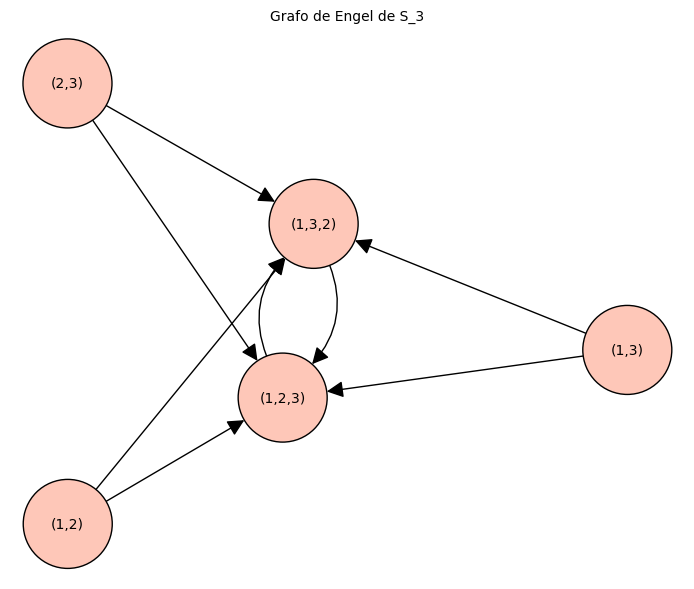

In [19]:
# ========== EJEMPLOS ==========
print("\n" + "=" * 70)
print("EJEMPLO 1: S_3 (Grupo Simétrico)")
print("=" * 70)

S3 = SymmetricGroup(3)
Gamma_S3, vertices_S3 = grafo_engel(S3)

if Gamma_S3 is not None:
    
    # Mostrar información sobre la estructura
    print("\nAnálisis de simetría:")
    aristas = list(Gamma_S3.edges(labels=False))
    for u, v in aristas[:5]:  # Mostrar primeras 5 aristas
        tiene_reciproca = Gamma_S3.has_edge(v, u)
        print(f"  {u} → {v}: recíproca {v} → {u} = {tiene_reciproca}")
    
    Gamma_S3.show(figsize=8, vertex_size=1000, title="Grafo de Engel de S_3")

In [20]:
# ========== EJEMPLOS ==========
print("\n" + "=" * 70)
print("EJEMPLO 1: A_3 (Alternante de orden 3)")
print("=" * 70)

A3 = AlternatingGroup(3)
Gamma_A3, vertices_A3 = grafo_engel(A3)

if Gamma_A3 is not None:
    
    # Mostrar información sobre la estructura
    print("\nAnálisis de simetría:")
    aristas = list(Gamma_A3.edges(labels=False))
    for u, v in aristas[:5]:  # Mostrar primeras 5 aristas
        tiene_reciproca = Gamma_A3.has_edge(v, u)
        print(f"  {u} → {v}: recíproca {v} → {u} = {tiene_reciproca}")
    
    Gamma_A3.show(figsize=8, vertex_size=1000, title="Grafo de Engel de A_3")


EJEMPLO 1: A_3 (Alternante de orden 3)
Grupo: Alternating group of order 3!/2 as a permutation group
Orden: 3

Hipercentro Z_∞(G):
  Orden: 3
  Elementos: [(), (1,3,2), (1,2,3)]

Vértices (G \ Z_∞(G)): 0
  []

⚠️  El grafo es vacío (Z_∞(G) = G)



EJEMPLO 1: S_4 (Grupo Simétrico)
Grupo: Symmetric group of order 4! as a permutation group
Orden: 24

Hipercentro Z_∞(G):
  Orden: 1
  Elementos: [()]

Vértices (G \ Z_∞(G)): 23

Calculando aristas...



Análisis de simetría:
  (1,3)(2,4) → (1,3,4,2): recíproca (1,3,4,2) → (1,3)(2,4) = True
  (1,3)(2,4) → (1,4)(2,3): recíproca (1,4)(2,3) → (1,3)(2,4) = True
  (1,3)(2,4) → (1,4): recíproca (1,4) → (1,3)(2,4) = True
  (1,3)(2,4) → (1,2)(3,4): recíproca (1,2)(3,4) → (1,3)(2,4) = True
  (1,3)(2,4) → (1,2,4,3): recíproca (1,2,4,3) → (1,3)(2,4) = True


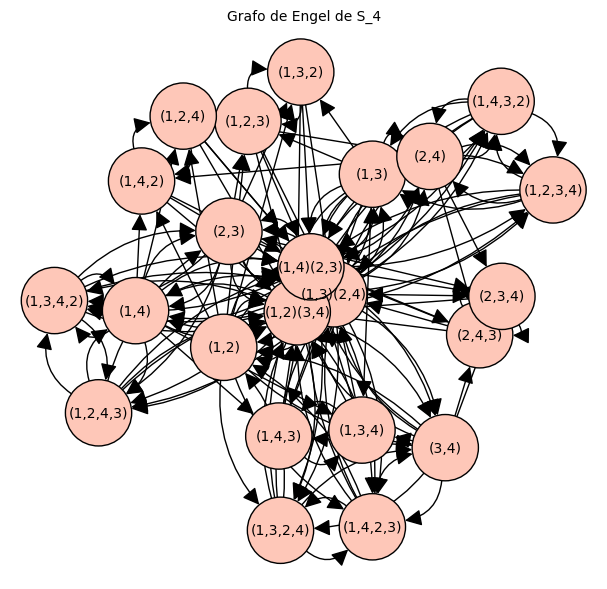

In [21]:
# ========== EJEMPLOS ==========
print("\n" + "=" * 70)
print("EJEMPLO 1: S_4 (Grupo Simétrico)")
print("=" * 70)

S4 = SymmetricGroup(4)
Gamma_S4, vertices_4 = grafo_engel(S4)

if Gamma_S4 is not None:
    
    # Mostrar información sobre la estructura
    print("\nAnálisis de simetría:")
    aristas = list(Gamma_S4.edges(labels=False))
    for u, v in aristas[:5]:  # Mostrar primeras 5 aristas
        tiene_reciproca = Gamma_S4.has_edge(v, u)
        print(f"  {u} → {v}: recíproca {v} → {u} = {tiene_reciproca}")
    
    Gamma_S4.show(figsize=8, vertex_size=1000, title="Grafo de Engel de S_4")


EJEMPLO 1: S_3 (Grupo Simétrico)
Grupo: Alternating group of order 4!/2 as a permutation group
Orden: 12

Hipercentro Z_∞(G):
  Orden: 1
  Elementos: [()]

Vértices (G \ Z_∞(G)): 11

Calculando aristas...

Análisis de simetría:
  (1,2)(3,4) → (1,3)(2,4): recíproca (1,3)(2,4) → (1,2)(3,4) = True
  (1,2)(3,4) → (1,4)(2,3): recíproca (1,4)(2,3) → (1,2)(3,4) = True
  (1,3)(2,4) → (1,2)(3,4): recíproca (1,2)(3,4) → (1,3)(2,4) = True
  (1,3)(2,4) → (1,4)(2,3): recíproca (1,4)(2,3) → (1,3)(2,4) = True
  (1,4)(2,3) → (1,2)(3,4): recíproca (1,2)(3,4) → (1,4)(2,3) = True


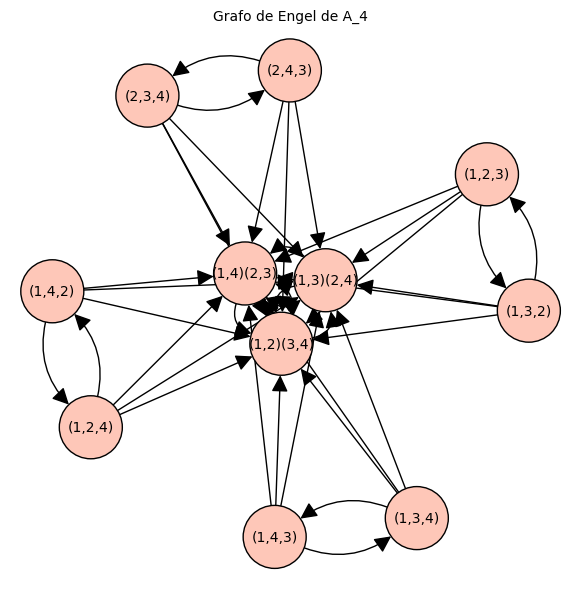

In [22]:
# ========== EJEMPLOS ==========
print("\n" + "=" * 70)
print("EJEMPLO 1: S_3 (Grupo Simétrico)")
print("=" * 70)

A4 = AlternatingGroup(4)
Gamma_A4, vertices_A4 = grafo_engel(A4)

if Gamma_A4 is not None:
    
    # Mostrar información sobre la estructura
    print("\nAnálisis de simetría:")
    aristas = list(Gamma_A4.edges(labels=False))
    for u, v in aristas[:5]:  # Mostrar primeras 5 aristas
        tiene_reciproca = Gamma_A4.has_edge(v, u)
        print(f"  {u} → {v}: recíproca {v} → {u} = {tiene_reciproca}")
    
    Gamma_A4.show(figsize=8, vertex_size=1000, title="Grafo de Engel de A_4")

In [23]:
print("\n" + "=" * 70)
print("EJEMPLO 1: D4 (Diehdrico de orde 8)")
print("=" * 70)

D4 = DihedralGroup(2)
Gamma_D4, vertices_D4 = grafo_engel(D4)

if Gamma_D4 is not None:
    
    # Mostrar información sobre la estructura
    print("\nAnálisis de simetría:")
    aristas = list(Gamma_D4.edges(labels=False))
    for u, v in aristas[:5]:  # Mostrar primeras 5 aristas
        tiene_reciproca = Gamma_D4.has_edge(v, u)
        print(f"  {u} → {v}: recíproca {v} → {u} = {tiene_reciproca}")
    
    Gamma_D4.show(figsize=8, vertex_size=1000, title="Grafo de Engel de Diehdrico de orde 8")


EJEMPLO 1: D4 (Diehdrico de orde 8)
Grupo: Dihedral group of order 4 as a permutation group
Orden: 4

Hipercentro Z_∞(G):
  Orden: 4
  Elementos: [(), (3,4), (1,2), (1,2)(3,4)]

Vértices (G \ Z_∞(G)): 0
  []

⚠️  El grafo es vacío (Z_∞(G) = G)



EJEMPLO 1: D5 (Diehdrico de orde 10)
Grupo: Dihedral group of order 10 as a permutation group
Orden: 10

Hipercentro Z_∞(G):
  Orden: 1
  Elementos: [()]

Vértices (G \ Z_∞(G)): 9
  [(1,5,4,3,2), (1,4,2,5,3), (1,3,5,2,4), (1,2,3,4,5), (2,5)(3,4), (1,5)(2,4), (1,4)(2,3), (1,3)(4,5), (1,2)(3,5)]

Calculando aristas...

Análisis de simetría:
  (1,5,4,3,2) → (1,4,2,5,3): recíproca (1,4,2,5,3) → (1,5,4,3,2) = True
  (1,5,4,3,2) → (1,3,5,2,4): recíproca (1,3,5,2,4) → (1,5,4,3,2) = True
  (1,5,4,3,2) → (1,2,3,4,5): recíproca (1,2,3,4,5) → (1,5,4,3,2) = True
  (1,4,2,5,3) → (1,5,4,3,2): recíproca (1,5,4,3,2) → (1,4,2,5,3) = True
  (1,4,2,5,3) → (1,3,5,2,4): recíproca (1,3,5,2,4) → (1,4,2,5,3) = True


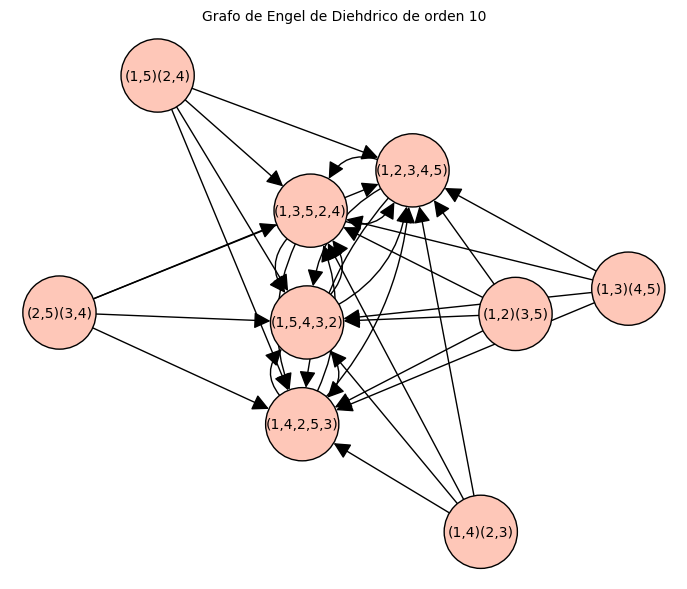

In [24]:
print("\n" + "=" * 70)
print("EJEMPLO 1: D5 (Diehdrico de orde 10)")
print("=" * 70)

D5 = DihedralGroup(5)
Gamma_D5, vertices_D5 = grafo_engel(D5)

if Gamma_D5 is not None:
    
    # Mostrar información sobre la estructura
    print("\nAnálisis de simetría:")
    aristas = list(Gamma_D5.edges(labels=False))
    for u, v in aristas[:5]:  # Mostrar primeras 5 aristas
        tiene_reciproca = Gamma_D5.has_edge(v, u)
        print(f"  {u} → {v}: recíproca {v} → {u} = {tiene_reciproca}")
    
    Gamma_D5.show(figsize=8, vertex_size=1000, title="Grafo de Engel de Diehdrico de orden 10")


EJEMPLO 1: D6 (Diehdrico de orde 12)
Grupo: Dihedral group of order 12 as a permutation group
Orden: 12

Hipercentro Z_∞(G):
  Orden: 2
  Elementos: [(), (1,4)(2,5)(3,6)]

Vértices (G \ Z_∞(G)): 10
  [(1,5,3)(2,6,4), (1,3,5)(2,4,6), (1,6,5,4,3,2), (1,2,3,4,5,6), (2,6)(3,5), (1,5)(2,4), (1,3)(4,6), (1,6)(2,5)(3,4), (1,4)(2,3)(5,6), (1,2)(3,6)(4,5)]

Calculando aristas...

Análisis de simetría:
  (1,5,3)(2,6,4) → (1,3,5)(2,4,6): recíproca (1,3,5)(2,4,6) → (1,5,3)(2,6,4) = True
  (1,5,3)(2,6,4) → (1,6,5,4,3,2): recíproca (1,6,5,4,3,2) → (1,5,3)(2,6,4) = True
  (1,5,3)(2,6,4) → (1,2,3,4,5,6): recíproca (1,2,3,4,5,6) → (1,5,3)(2,6,4) = True
  (1,3,5)(2,4,6) → (1,5,3)(2,6,4): recíproca (1,5,3)(2,6,4) → (1,3,5)(2,4,6) = True
  (1,3,5)(2,4,6) → (1,6,5,4,3,2): recíproca (1,6,5,4,3,2) → (1,3,5)(2,4,6) = True


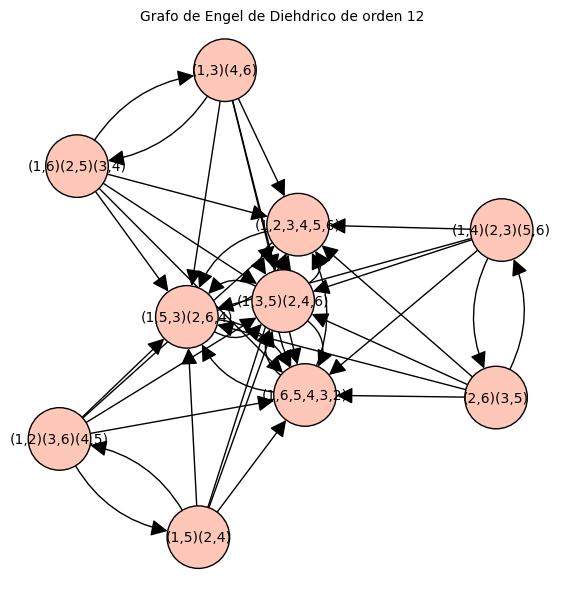

In [27]:
print("\n" + "=" * 70)
print("EJEMPLO 1: D6 (Diehdrico de orde 12)")
print("=" * 70)

D6 = DihedralGroup(6)
Gamma_D6, vertices_D6 = grafo_engel(D6)

if Gamma_D6 is not None:
    
    # Mostrar información sobre la estructura
    print("\nAnálisis de simetría:")
    aristas = list(Gamma_D6.edges(labels=False))
    for u, v in aristas[:5]:  # Mostrar primeras 5 aristas
        tiene_reciproca = Gamma_D6.has_edge(v, u)
        print(f"  {u} → {v}: recíproca {v} → {u} = {tiene_reciproca}")
    
    Gamma_D6.show(figsize=8, vertex_size=1000, title="Grafo de Engel de Diehdrico de orden 12")

In [26]:
def analizar_grupo(G, nombre):
    """Analiza un grupo y retorna datos básicos"""
    Z_inf = calcular_hipercentro(G)
    Gamma, vertices = grafo_engel(G, verbose=False)
    
    return {
        'nombre': nombre,
        'orden': G.order(),
        'hipercentro': Z_inf.order(),
        'vertices': len(vertices),
        'aristas': Gamma.size() if Gamma else 0,
        'fuertemente_conexo': Gamma.is_strongly_connected() if Gamma else False,
        'nilpotente': (Z_inf == G),
        'grafo_vacio': (Gamma is None)
    }


def tabla_resumen(datos_list):
    """Imprime tabla de resultados"""
    print("\n" + "="*80)
    print("TABLA DE RESULTADOS")
    print("="*80)
    print(f"{'Grupo':<10} {'|G|':<6} {'|Z∞|':<7} {'|V|':<6} {'|E|':<8} {'F.Conexo':<11} {'Nilp':<6}")
    print("-"*80)
    
    for d in datos_list:
        if d['grafo_vacio']:
            print(f"{d['nombre']:<10} {d['orden']:<6} {d['hipercentro']:<7} {'--':<6} {'--':<8} {'--':<11} {'Sí':<6}")
        else:
            fc = "Sí" if d['fuertemente_conexo'] else "No"
            nilp = "Sí" if d['nilpotente'] else "No"
            print(f"{d['nombre']:<10} {d['orden']:<6} {d['hipercentro']:<7} {d['vertices']:<6} {d['aristas']:<8} {fc:<11} {nilp:<6}")
    
    print("="*80)


def verificar_nilpotencia(datos_list):
    """Verifica: G nilpotente ⟺ Γ_G vacío"""
    print("\n" + "="*80)
    print("VERIFICACIÓN: G nilpotente ⟺ Γ_G vacío")
    print("="*80)
    
    todos_ok = True
    for d in datos_list:
        cumple = (d['nilpotente'] == d['grafo_vacio'])
        simbolo = "✓" if cumple else "✗"
        print(f"{simbolo} {d['nombre']:<10} Nilpotente: {str(d['nilpotente']):<5}  Grafo vacío: {d['grafo_vacio']}")
        if not cumple:
            todos_ok = False
    
    print("="*80)
    if todos_ok:
        print("✓ VERIFICADO: G nilpotente ⟺ Γ_G vacío")
    else:
        print("✗ CONTRAEJEMPLO ENCONTRADO")
    print()


# ========== ANÁLISIS ==========

print("\nANALIZANDO GRUPOS...\n")

# Definir grupos a estudiar
grupos = [
    # Simétricos
    ("S_3", SymmetricGroup(3)),
    ("S_4", SymmetricGroup(4)),
    ("S_5", SymmetricGroup(5)),
    # Diédricos
    ("D_3", DihedralGroup(3)),
    ("D_4", DihedralGroup(4)),
    ("D_5", DihedralGroup(5)),
    ("D_6", DihedralGroup(6)),
    ("D_7", DihedralGroup(7)),
    ("D_8", DihedralGroup(8)),
    
    # Nilpotentes (para verificar)
    ("C_4", CyclicPermutationGroup(4)),
    ("C_6", CyclicPermutationGroup(6)),
    ("Q_8", QuaternionGroup()),
]

# Analizar todos
resultados = []
for nombre, G in grupos:
    print(f"  {nombre}...", end=" ")
    datos = analizar_grupo(G, nombre)
    resultados.append(datos)
    print("✓")

# Mostrar resultados
tabla_resumen(resultados)
verificar_nilpotencia(resultados)

print("\nOBSERVACIONES:")
print("- Para S_n: ¿|V| = |G| - 1?")
print("- Para D_n: ¿Diferencia entre n par e impar?")
print("- ¿Todos los nilpotentes tienen grafo vacío?")


ANALIZANDO GRUPOS...

  S_3... ✓
  S_4... 

✓
  S_5... 

✓
  D_3... ✓
  D_4... ✓
  D_5... ✓
  D_6... ✓
  D_7... ✓
  D_8... ✓
  C_4... ✓
  C_6... ✓
  Q_8... ✓

TABLA DE RESULTADOS
Grupo      |G|    |Z∞|    |V|    |E|      F.Conexo    Nilp  
--------------------------------------------------------------------------------
S_3        6      1       5      8        No          No    
S_4        24     1       23     170      Sí          No    
S_5        120    1       119    1802     Sí          No    
D_3        6      1       5      8        No          No    
D_4        8      8       --     --       --          Sí    
D_5        10     1       9      32       No          No    
D_6        12     2       10     42       No          No    
D_7        14     1       13     72       No          No    
D_8        16     16      --     --       --          Sí    
C_4        4      4       --     --       --          Sí    
C_6        6      6       --     --       --          Sí    
Q_8        8      8       --     --       --          Sí    

VER